In [3]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import PIL
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import shutil
import re
import pathlib

print(np.__version__)

1.19.2


# Data preperation

In [ ]:
# Create folders
datadirRaw = 'data/Test C'
dirNames = ['0-25', '26-50', '51-75', '76-100']

for dirName in dirNames:
    if not os.path.exists(dirName):
        os.mkdir(datadirRaw + '_' + dirName)
        print("Directory " , dirName ,  " Created ")
    else:    
        print("Directory " , dirName ,  " already exists")

In [ ]:
# Move images into correct folder (based on names)
srcpath = 'data/Video/Test A/'
dataset_size = 4189
quartile_1_directory = "data/Test C_0-25"
quartile_2_directory = "data/Test C_26-50"
quartile_3_directory = "data/Test C_51-75"
quartile_4_directory = "data/Test C_76-100"

fullpath = os.path.join

for dirname, dirnames, filenames in os.walk(srcpath):
    for filename in filenames:
        print(filename)
        source = fullpath(dirname, filename)
        cycle_number = re.search('_(.*).jpg', filename)

        if 0 <= int(cycle_number.group(1)) <= int(dataset_size/4):
            shutil.copy(source, fullpath(quartile_1_directory, filename))

        elif int(dataset_size/4) < int(cycle_number.group(1)) <= int(dataset_size/2):
            shutil.copy(source, fullpath(quartile_2_directory, filename))

        elif int(dataset_size/2) < int(cycle_number.group(1)) <= int(dataset_size/(4/3)):
            shutil.copy(source, fullpath(quartile_3_directory, filename))

        elif int(dataset_size/(4/3)) < int(cycle_number.group(1)) <= dataset_size:
            shutil.copy(source, fullpath(quartile_4_directory, filename))
        
        print('Moved file: ' + filename)

# Model & Training

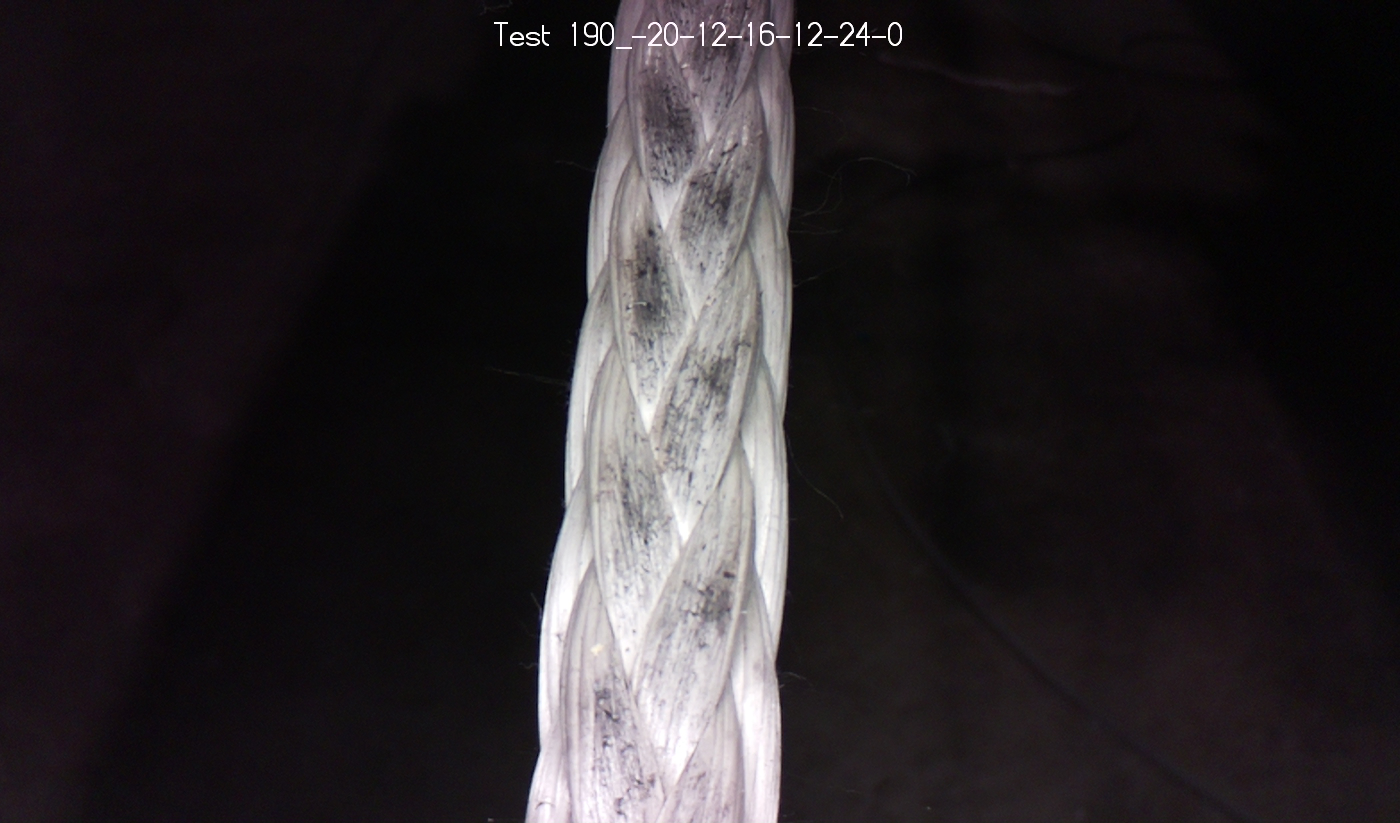

In [4]:
# Print a picture
data_dir = 'data' 
data_dir = pathlib.Path(data_dir)
roses = list(data_dir.glob('Test C_0-25/*'))
PIL.Image.open(str(roses[0]))

In [5]:
# Size of dataset
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

4189


In [6]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)  

Found 4197 files belonging to 4 classes.
Using 3358 files for training.
Found 4197 files belonging to 4 classes.
Using 839 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['Test C_0-25', 'Test C_26-50', 'Test C_51-75', 'Test C_76-100']


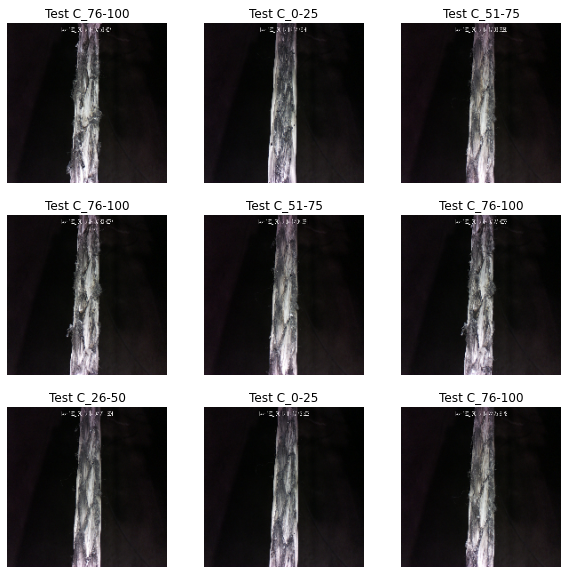

In [9]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [82]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [83]:
normalization_layer = layers.experimental.preprocessing.Rescaling(1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixels values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [97]:
num_classes = 4

data_augmentation = keras.Sequential([layers.experimental.preprocessing.RandomFlip("horizontal", input_shape=(img_height, img_width,3)),
    layers.experimental.preprocessing.RandomRotation(0.3),
    layers.experimental.preprocessing.RandomZoom(0.4),
  ]
)

model = Sequential([
  data_augmentation,
  layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.3),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

In [98]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [99]:
model.summary()

Model: "sequential_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_30 (Sequential)   (None, 180, 180, 3)       0         
_________________________________________________________________
rescaling_17 (Rescaling)     (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_45 (Conv2D)           (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_29 (Dropout)         (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 45, 45, 32)      

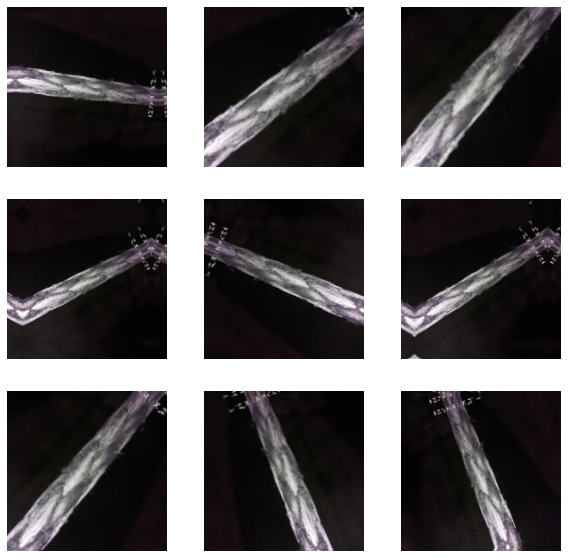

In [100]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

In [75]:
epochs=15
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
105/105 [==============================] - 79s 735ms/step - loss: 1.3880 - accuracy: 0.2793 - val_loss: 1.3734 - val_accuracy: 0.2741
Epoch 2/30
105/105 [==============================] - 68s 648ms/step - loss: 1.2912 - accuracy: 0.3776 - val_loss: 1.1214 - val_accuracy: 0.5161
Epoch 3/30
105/105 [==============================] - 69s 660ms/step - loss: 1.0726 - accuracy: 0.5155 - val_loss: 1.4667 - val_accuracy: 0.2634
Epoch 4/30
105/105 [==============================] - 71s 675ms/step - loss: 0.9842 - accuracy: 0.5587 - val_loss: 0.8427 - val_accuracy: 0.7330
Epoch 5/30
105/105 [==============================] - 67s 637ms/step - loss: 0.8239 - accuracy: 0.6522 - val_loss: 0.6467 - val_accuracy: 0.7473
Epoch 6/30
105/105 [==============================] - 70s 666ms/step - loss: 0.6794 - accuracy: 0.7094 - val_loss: 0.6740 - val_accuracy: 0.6603
Epoch 7/30
105/105 [==============================] - 69s 660ms/step - loss: 0.5843 - accuracy: 0.7540 - val_loss: 0.4904 - val_ac

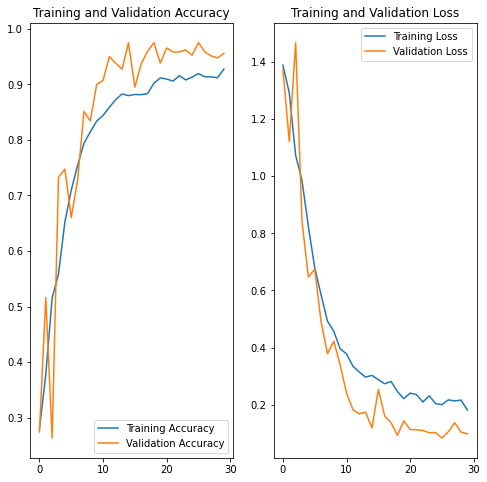

In [76]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [80]:
img = keras.preprocessing.image.load_img(
    'Video/test_data\q3.jpg', target_size=(img_height, img_width)
)
img_array = keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

This image most likely belongs to Test C_76-100 with a 54.46 percent confidence.


In [ ]:
C:\Users\Lasse Göncz\Github\cv_ropes\Video\test_data